# Importación de librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

Comprobación del uso de GPU y dispositivos físicos.

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0


# Procesamiento de datos

Nuestro dataset ya se encuentra dividido en test, train y validation, por lo que solo es necesario acceder a ellos por medio del path para poder procesarlos.

In [3]:
train_path = 'Food/training'
validation_path = 'Food/validation'
test_path = 'Food/evaluation'

En este caso manejaremos un dataset de tipos de comida, siendo dividido en 11 clases:

- Bread
- Dairy product
- Dessert
- Egg
- Fried food
- Meat
- Noodles-Pasta
- Rice
- Seafood
- Soup
- Vegetable-Fruit

Por lo tanto deberemos manejar un modelo categórico, de manera que podamos clasificar y agrupar los datos que sean introducidos al modelo según sus características.

Se utilizó como base el modelo *VGG16* para el entrenamiento del modelo.

In [4]:
# Para mejorar el aprendizaje del modelo y ampliar el set de entrenamiento, se generaron nuevas imágenes basadas en las originales pero con ciertas modificaciones.
train_datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 40,
							width_shift_range = 0.2,
							height_shift_range = 0.2,
							shear_range = 0.2,
							zoom_range = 0.2,
							horizontal_flip = True,)

train_generator = train_datagen.flow_from_directory(
							train_path,
							target_size = (150, 150),
							batch_size = 20,
							class_mode ='categorical')

val_datagen = ImageDataGenerator(1./255)

val_generator = val_datagen.flow_from_directory(
							validation_path,
							target_size = (150,150),
							batch_size =20,
							class_mode= 'categorical')

test_datagen = ImageDataGenerator(1./255)

test_generator = test_datagen.flow_from_directory(
							test_path,
							target_size = (150, 150),
							batch_size = 20,
							class_mode= 'categorical')

conv_base= VGG16(weights='imagenet',
							include_top = False,
							input_shape = (150,150,3))

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.
Found 3347 images belonging to 11 classes.


# Primera iteración

## Preparación del modelo

Para la primera iteración se utilizó un modelo secuencial, nuevamente, tomando como base *VGG16*. Dado que la base ya fue previamente entrenada, el parámetro para que siga aprendiendo será falso.

Una vez que haya terminado se transformarán los datos en un arreglo con una capa de Flatten y se clasificarán por medio de dos capas densas.

In [5]:
model1 = models.Sequential()
model1.add(conv_base)
model1.add(layers.Flatten())
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(11,activation='softmax'))

conv_base.trainable = False

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 11)                2827      
                                                                 
Total params: 16,814,923
Trainable params: 2,100,235
Non-trainable params: 14,714,688
_________________________________________________________________


Al compilar el modelo se utilizará el RMSprop como optimizer, con una tasa de aprendizaje de 0.0002.

- RMSprop trabaja manteniendo un promedio móvil sobre el cuadrado de los gradientes y dividiendo el gradiente entre la raíz de este promedio.

La pérdida se calculará con un Cross Entropy categórico dado que estamos trabjando con diversas clases.

La medida de aprendizaje será en accurancy.

In [6]:
model1.compile(loss='categorical_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=2e-5),
						metrics=['acc'])

Para el entrenamiento del modelo mantendremos 30 steps por cada época, con un total de 15 épocas.

En cuanto a la validación utilizaremos 25 steps.

In [7]:
history = model1.fit(train_generator, 
				steps_per_epoch = 30, 
				epochs = 15, 
				validation_data = val_generator, 
				validation_steps = 25)

Epoch 1/15


c:\Users\quiqu\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


30/30 [==============================] - 50s 2s/step - loss: 21.7000 - acc: 0.1200 - val_loss: 16.5464 - val_acc: 0.1840
Epoch 2/15
30/30 [==============================] - 49s 2s/step - loss: 16.6126 - acc: 0.1733 - val_loss: 13.7937 - val_acc: 0.2340
Epoch 3/15
30/30 [==============================] - 49s 2s/step - loss: 12.7806 - acc: 0.2400 - val_loss: 13.7053 - val_acc: 0.2380
Epoch 4/15
30/30 [==============================] - 49s 2s/step - loss: 11.8210 - acc: 0.2583 - val_loss: 12.2904 - val_acc: 0.2520
Epoch 5/15
30/30 [==============================] - 49s 2s/step - loss: 11.2970 - acc: 0.3050 - val_loss: 12.0957 - val_acc: 0.2820
Epoch 6/15
30/30 [==============================] - 49s 2s/step - loss: 9.9933 - acc: 0.3033 - val_loss: 10.4160 - val_acc: 0.2940
Epoch 7/15
30/30 [==============================] - 51s 2s/step - loss: 9.4277 - acc: 0.3183 - val_loss: 10.8169 - val_acc: 0.3240
Epoch 8/15
30/30 [==============================] - 52s 2s/step - loss: 8.0119 - acc: 0.4

## Resultados

Guardamos los resultados del modelo en diferentes variables.

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [9]:
epochs = range(1, len(acc)+1)

Gráfica de resultados

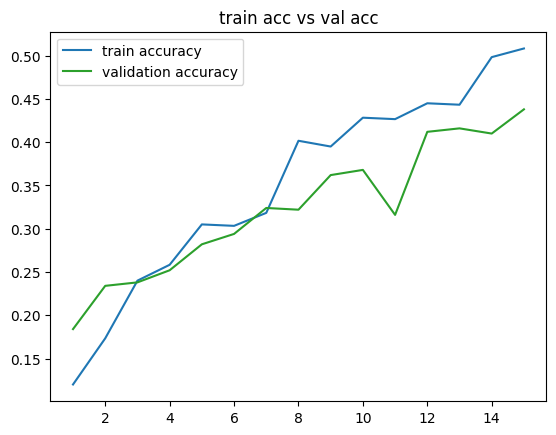

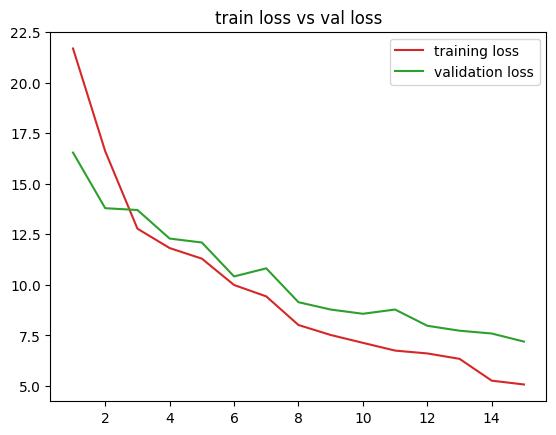

In [10]:
plt.plot(epochs,acc,'tab:blue',label='train accuracy')
plt.plot(epochs,val_acc, 'tab:green', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'tab:red', label ='training loss')
plt.plot(epochs,val_loss, 'tab:green', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

Podemos ver que el modelo aprende correctamente aunque a un ritmo ciertamente lento. La validación está ligeramente por debajo del entrenamiento, contando con un 50.83% de accurancy y un 43.80% de validation. Por otra parte, la pérdida disminuye a un ritmo constante, lo cual es un buen indicador, aunque podría disminuir aún más.

Finalmente con el set de test podemos ver una accurancy del 43.39%, lo que indica que nuestro modelo está ligeramente con overfitting.

A simple vista podemos deducir que el modelo requiere de más tiempo de aprendizaje, ajustando los hiperparámetros para llegar a los resultados esperados.

In [11]:
test_loss, test_acc = model1.evaluate(test_generator, steps = 25)
print('\ntest acc :\n', test_acc)

25/25 [==============================] - 22s 894ms/step - loss: 7.7311 - acc: 0.4340

test acc :
 0.4339999854564667


# Segunda iteración

## Preparación del modelo

Para la segunda iteración se utilizó la misma base del modelo anterior, pues parecía apuntar a una dirección adecuada, por lo que se optó por ajustar los hiper parámetros.

In [12]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(11,activation='softmax'))

conv_base.trainable = False

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 11)                2827      
                                                                 
Total params: 16,814,923
Trainable params: 2,100,235
Non-trainable params: 14,714,688
_________________________________________________________________


Al compilar el modelo se nuevamente se utilió el RMSprop como optimizer, pero ahora una tasa de aprendizaje de 0.0001.

La pérdida se calculará con un Cross Entropy categórico dado que estamos trabjando con diversas clases.

La medida de aprendizaje será en accurancy.

In [13]:
model2.compile(loss='categorical_crossentropy',
						optimizer=optimizers.RMSprop(learning_rate=1e-5),
						metrics=['acc'])

Los parámetros de aprendizaje fueron incrementados para mejorar el rendimiento del modelo.

Se incrementaron a 65 los steps por cada época, con ahora un total de 50 épocas.

En cuanto a la validación utilizaremos 60 steps.

In [14]:
history = model2.fit(train_generator, 
				steps_per_epoch = 65, 
				epochs = 50, 
				validation_data = val_generator, 
				validation_steps = 60)

Epoch 1/50
65/65 [==============================] - 114s 2s/step - loss: 21.1187 - acc: 0.1023 - val_loss: 17.9409 - val_acc: 0.1358
Epoch 2/50
65/65 [==============================] - 118s 2s/step - loss: 15.3545 - acc: 0.2069 - val_loss: 14.4586 - val_acc: 0.2050
Epoch 3/50
65/65 [==============================] - 113s 2s/step - loss: 12.7975 - acc: 0.2438 - val_loss: 12.9326 - val_acc: 0.2450
Epoch 4/50
65/65 [==============================] - 117s 2s/step - loss: 11.4329 - acc: 0.3040 - val_loss: 11.5979 - val_acc: 0.2967
Epoch 5/50
65/65 [==============================] - 113s 2s/step - loss: 10.4497 - acc: 0.3238 - val_loss: 10.9922 - val_acc: 0.3108
Epoch 6/50
65/65 [==============================] - 113s 2s/step - loss: 9.0322 - acc: 0.3492 - val_loss: 10.5038 - val_acc: 0.3375
Epoch 7/50
65/65 [==============================] - 112s 2s/step - loss: 8.3631 - acc: 0.3900 - val_loss: 9.6817 - val_acc: 0.3367
Epoch 8/50
65/65 [==============================] - 114s 2s/step - loss:

## Resultados

Guardamos los resultados del modelo en diferentes variables.

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [17]:
epochs = range(1, len(acc)+1)

Gráfica de resultados

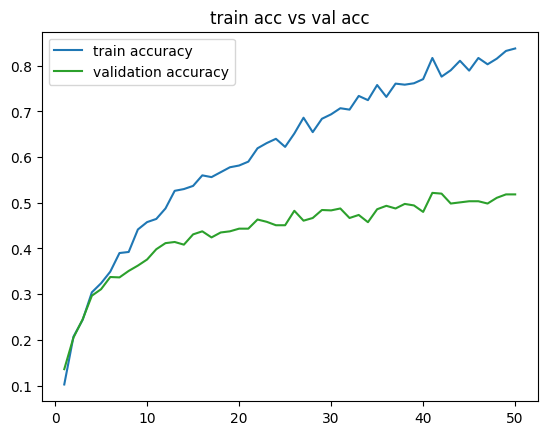

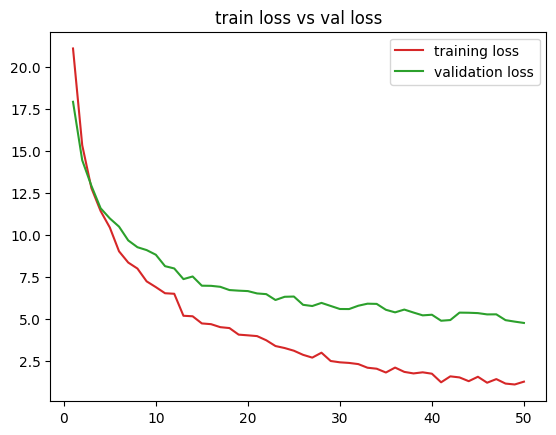

In [18]:
plt.plot(epochs,acc,'tab:blue',label='train accuracy')
plt.plot(epochs,val_acc, 'tab:green', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'tab:red', label ='training loss')
plt.plot(epochs,val_loss, 'tab:green', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

Con este nuevo modelo se aprecia una notable diferencia, cuenta con un 83.77% de accurancy y un 51.83% de validation. Así como una ligera disminución en la pérdida.

Al realizar estos ajustes al modelo, este mejoró significativamente en el entrenamiento. Sin embargo, dada la cantidad y calidad de nuestros datos, se mantuvo con un overfitting ligeramente elevado.

Comprobando con el set de test llegamos a un accurancy del 56%, siendo mayor que el modelo anterior.

In [20]:
test_loss, test_acc = model2.evaluate(test_generator, steps = 50)
print('\ntest acc :\n', test_acc)

50/50 [==============================] - 36s 713ms/step - loss: 4.5431 - acc: 0.5610

test acc :
 0.5609999895095825


## Guardado del modelo

In [15]:
model2.save('Food_Classification.h5')

# Conclusiones

*Mejora en accurancy:*
*50.83% => 83.77%*

*Mejora en validation:*
*43.80% => 51.83%*

*Mejora en test:*
*43.39% => 56.09%*

En general hubo una mejoría en el rendimiento del modelo, con un incremento del 32.94% en la accurancy, así como una mejora de aproximádamente un 10% en el validation y en el test.

Ciertamente es notorio el overfitting en el modelo, pues a pesar de su buen desempeño en el entrenamiento, sus resultados de validación eran inferiores. Lo que nos indica que para ese punto más que aprender de los datos, los estaba memorizando, esto se puede deber a que la calidad y variedad de los datos no era la óptima, pues a pesar de tener una cantidad aceptable de imágenes para entrenar, estas podían ser fácilmente confundibles con otras clases.